# Table of Contents

* [Walltime](#Walltime)
* [Speedup](#Speedup)
* [Memory consumption](#Memory-consumption)
* [Exact counting](#Exact-counting)
	* [Table](#Table)
* [Streaming](#Streaming)
* [Summaries description](#Summaries-description)
	* [Reads stats](#Reads-stats)
	* [Walltime stats](#Walltime-stats)
	* [Memory stats](#Memory-stats)


# Initialization

In [1]:
import itertools
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns

#STYLE = 'seaborn-ticks'
#STYLE = 'seaborn-whitegrid'
STYLE = 'fivethirtyeight'

In [2]:
%run ../scripts/bench_to_csv.py
THREADS=[1,2,4,8,16,32,48,64,96]
THREADS_KMERSTREAM=[1,2,4,8,16,32]
REPLICATES = range(1, 11)

LINESTYLES = {
  3: ('--', '-.', '-'),
  4: ('--', '--', '-.', '-'),
  5: ('--', '--', '-.', '-', '-')
}

In [3]:
def prepare_io(summary, condition, value, threads):
    constant_line = None
    for t in threads:
        df = summary[['replicate', value, 'threads']].copy()
        df['threads'] = t
        df['condition'] = condition
        if constant_line is None:
            constant_line = df
        else:
            constant_line = constant_line.append(df, ignore_index=True)
    return constant_line


def tsplot(plot_data, value, ax, unit_traces=False):
    majorFormatter = FormatStrFormatter('%d')
    linestyles = itertools.cycle(LINESTYLES[len(plot_data)])
    plot_data = pd.concat(plot_data, ignore_index=True)

    err_style = 'ci_band'
    if unit_traces:
        err_style = 'unit_traces'

    sns.tsplot(plot_data, ax=ax, ci=95,
               err_style=err_style,
               linestyle='-', marker='o',
               time="threads", unit='replicate', condition='condition',
               value=value)
    for line in ax.lines:
        line.set_linestyle(next(linestyles))
    ax.lines[-1].set_marker("s")
    ax.set_xscale("log", basex=2)
    ax.xaxis.set_major_formatter(majorFormatter)

    ax.set_yscale("log", basey=2)
    ax.yaxis.set_major_formatter(majorFormatter)

    ax.legend(loc='best')

# Walltime

In [4]:
summary_io_kseq = parse_exp('just-io-kseq', REPLICATES, dir='../benchmarks')
summary_io_seqan = parse_exp('just-io-seqan', REPLICATES, dir='../benchmarks')

summary_hll_kseq = parse_exp('unique-kmers-kseq', REPLICATES, threads=THREADS, dir='../benchmarks')
summary_hll_kseq['condition'] = 'Parallel HLL (KSeq)'

summary_hll_seqan = parse_exp('unique-kmers-seqan', REPLICATES, threads=THREADS, dir='../benchmarks')
summary_hll_seqan['condition'] = 'Parallel HLL (SeqAn)'

summary_kmerstream = parse_exp('kmerstream', REPLICATES, threads=THREADS_KMERSTREAM, dir='../benchmarks')
summary_kmerstream['condition'] = 'KmerStream'

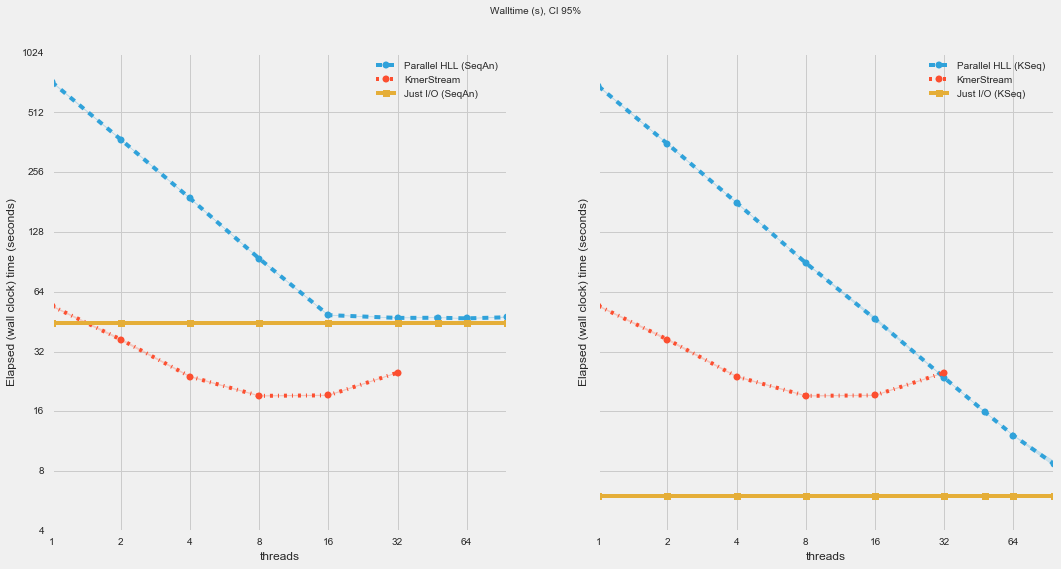

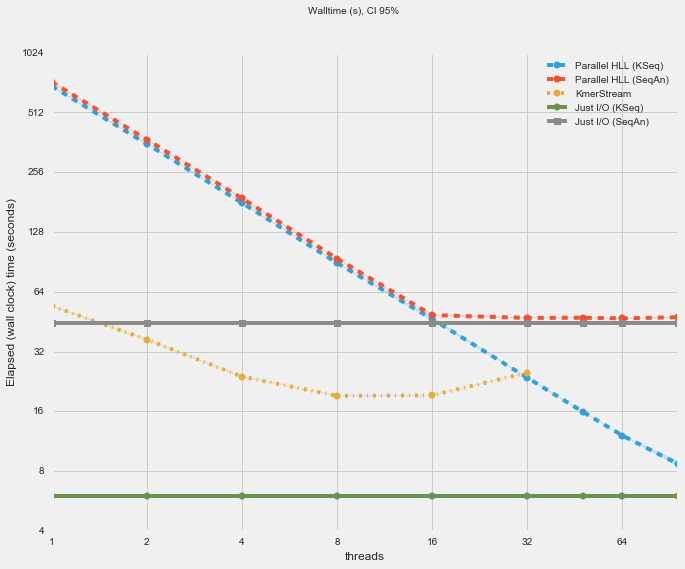

In [5]:
io = {}
io['kseq'] = prepare_io(summary_io_kseq, 
                        "Just I/O (KSeq)",
                        "Elapsed (wall clock) time (seconds)",
                        threads=THREADS)
io['seqan'] = prepare_io(summary_io_seqan,
                         "Just I/O (SeqAn)",
                         "Elapsed (wall clock) time (seconds)",
                         threads=THREADS)

with plt.style.context(STYLE):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
    tsplot([summary_hll_kseq, summary_kmerstream, io['kseq']], 
           "Elapsed (wall clock) time (seconds)",
           ax2)
    tsplot([summary_hll_seqan, summary_kmerstream, io['seqan']], 
           "Elapsed (wall clock) time (seconds)", 
           ax1)
    ax1.set_ylim(bottom=4)
    ax2.set_ylim(bottom=4)
    fig.suptitle("Walltime (s), CI 95%")
    fig.savefig('../manuscript/figures/io_bound_walltime.pdf')
    
with plt.style.context(STYLE):
    fig = plt.figure(figsize=(10, 8))
    tsplot([summary_hll_kseq, summary_hll_seqan, summary_kmerstream, io['kseq'], io['seqan']], 
           "Elapsed (wall clock) time (seconds)",
           fig.gca())
    fig.suptitle("Walltime (s), CI 95%")
    fig.savefig('../manuscript/figures/io_bound_walltime.pdf')

# Speedup

In [6]:
def add_speedup(summary):
    speedup_base = (summary[summary["threads"] == 1]["Elapsed (wall clock) time (seconds)"].median())
    summary['speedup'] = speedup_base / summary["Elapsed (wall clock) time (seconds)"]

add_speedup(io['seqan'])
add_speedup(io['kseq'])
add_speedup(summary_hll_seqan)
add_speedup(summary_hll_kseq)
add_speedup(summary_kmerstream)

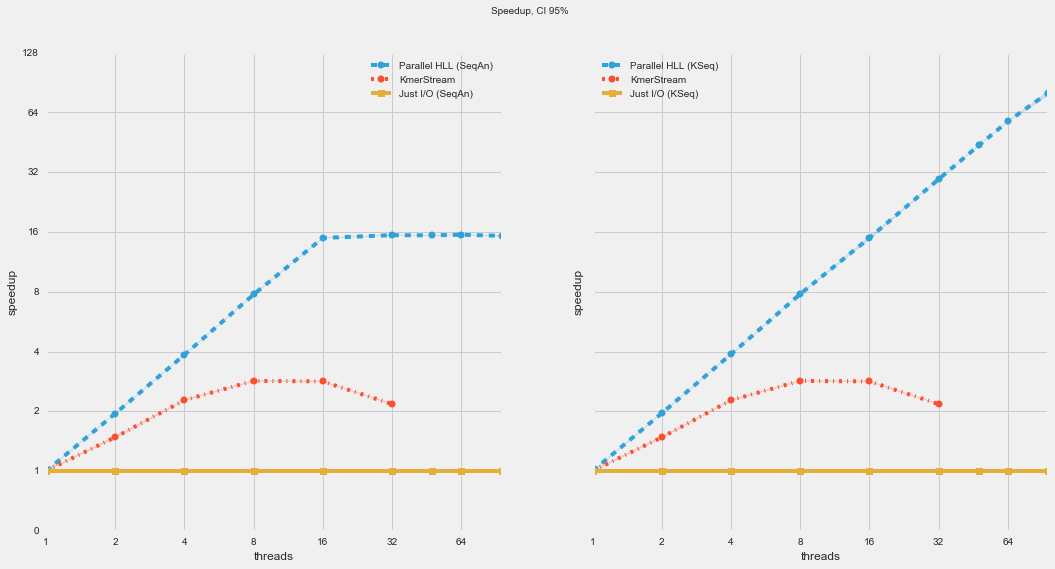

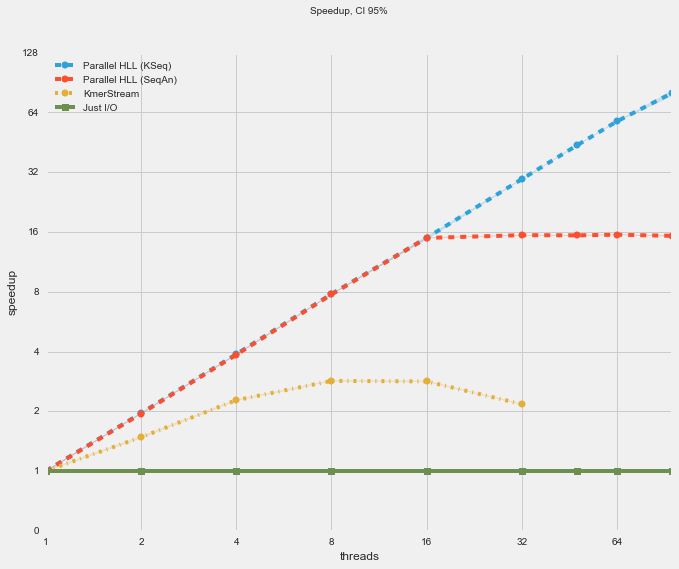

In [7]:
with plt.style.context(STYLE):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
    tsplot([summary_hll_kseq, summary_kmerstream, io['kseq']], 
           "speedup", 
           ax2)
    tsplot([summary_hll_seqan, summary_kmerstream, io['seqan']], 
           "speedup", 
           ax1)
    fig.suptitle("Speedup, CI 95%")
    fig.savefig('../manuscript/figures/io_bound_speedup.pdf')

io['seqan']['condition'] = 'Just I/O'
with plt.style.context(STYLE):
    fig = plt.figure(figsize=(10, 8))
    tsplot([summary_hll_kseq, summary_hll_seqan, summary_kmerstream, io['seqan']], 
           "speedup",
           fig.gca())
    fig.suptitle("Speedup, CI 95%")
    fig.savefig('../manuscript/figures/io_bound_speedup.pdf')

# Memory consumption

In [8]:
mem = {}
mem['kseq'] = prepare_io(summary_io_kseq, 
                        "Just I/O (KSeq)",
                        "Maximum resident set size (kbytes)",
                        threads=THREADS)
mem['seqan'] = prepare_io(summary_io_seqan,
                         "Just I/O (SeqAn)",
                         "Maximum resident set size (kbytes)",
                         threads=THREADS)

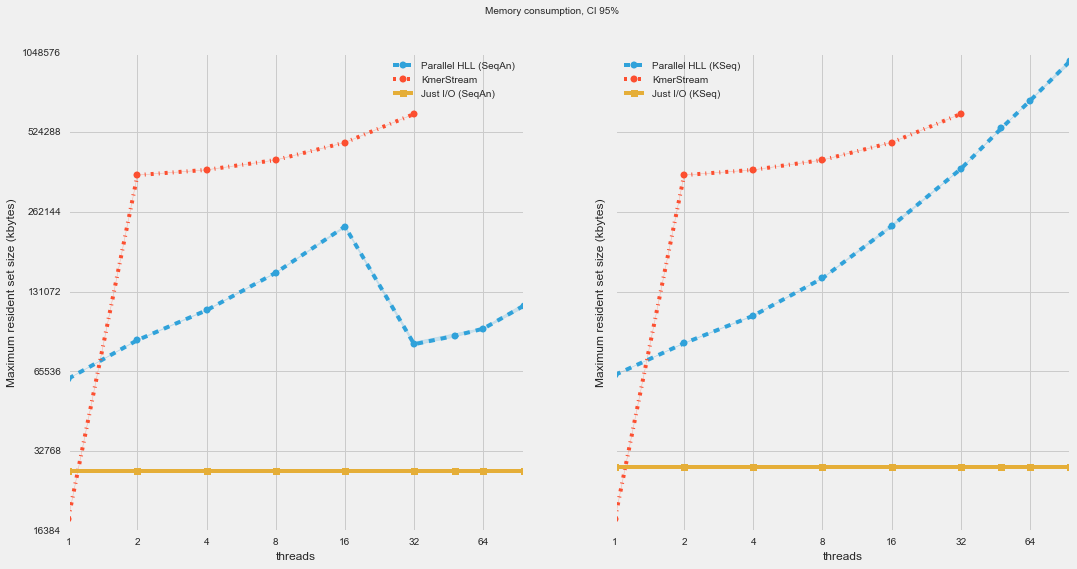

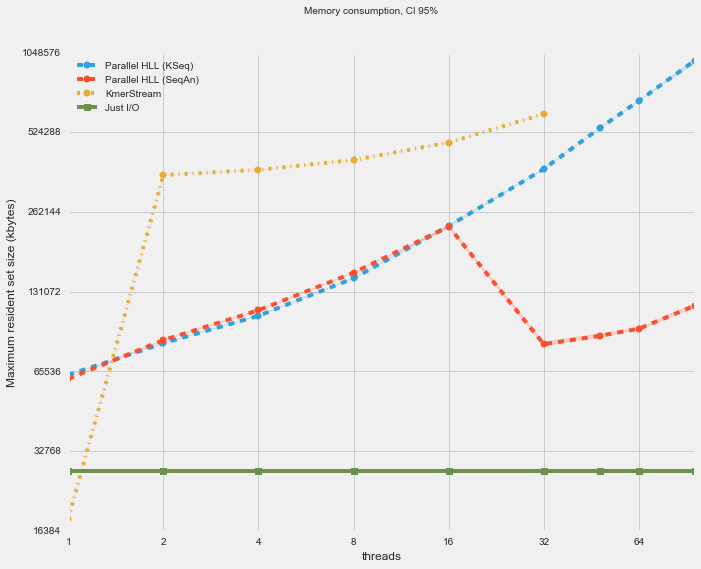

In [9]:
with plt.style.context(STYLE):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
    tsplot([summary_hll_kseq, summary_kmerstream, mem['kseq']], 
           "Maximum resident set size (kbytes)", 
           ax2)
    tsplot([summary_hll_seqan, summary_kmerstream, mem['seqan']], 
           "Maximum resident set size (kbytes)", 
           ax1)
    fig.suptitle("Memory consumption, CI 95%")
    fig.savefig('../manuscript/figures/mem_consumption.pdf')

mem['seqan']['condition'] = 'Just I/O'
with plt.style.context(STYLE):
    fig = plt.figure(figsize=(10, 8))
    tsplot([summary_hll_kseq, summary_hll_seqan, summary_kmerstream, mem['seqan']], 
           "Maximum resident set size (kbytes)", 
           fig.gca())
    fig.suptitle("Memory consumption, CI 95%")
    fig.savefig('../manuscript/figures/mem_consumption.pdf')

# Exact counting

In [10]:
summaries = {}
n_unique_kmers = {}

n_unique_kmers['small'] = {
  'py': 670487,
  'sparsehash': 670487,
  'hll': 670328
}

n_unique_kmers['medium'] = {
  'py': 17510301,
  'sparsehash': 17510301,
  'hll': 17686322
}

summaries['small'] = {
  'py':         parse_exp('exact-py-small', REPLICATES, dir='../benchmarks'),
  'sparsehash': parse_exp('exact-sparsehash-small', range(1, 11), dir='../benchmarks'),
  'hll':        parse_exp('hll-small', REPLICATES, dir='../benchmarks')
}
    
summaries['medium'] = {
  'py':         parse_exp('exact-py-medium', REPLICATES, threads=THREADS, dir='../benchmarks'),
  'sparsehash': parse_exp('exact-sparsehash-medium', range(1, 11), threads=THREADS, dir='../benchmarks'),
  'hll':        parse_exp('hll-medium', REPLICATES, threads=THREADS, dir='../benchmarks')
}

FileNotFoundError: [Errno 2] No such file or directory: '../benchmarks/exact-py-small_r01t01'

In [ ]:
dfs = {}
for size in ('small', 'medium'):
    df = pd.DataFrame()
    for src, summary in summaries[size].items():
        sr = summary[['Maximum resident set size (kbytes)', 'Elapsed (wall clock) time (seconds)']].mean()
        sr['implementation'] = src
        sr['cardinality'] = n_unique_kmers[size][src]
        df = df.append(sr, ignore_index=True)
    exact =  df[df['implementation'] == 'sparsehash']['cardinality'].values[0]
    df['error (%)'] = abs((df['cardinality'] - exact) / exact) * 100
    dfs[size] = df.set_index('implementation')

## Tables

In [ ]:
dfs['small'].sort_values(by='Elapsed (wall clock) time (seconds)')

In [ ]:
print(dfs['small'].sort_values(by='Elapsed (wall clock) time (seconds)').to_latex())

In [ ]:
dfs['medium'].sort_values(by='Elapsed (wall clock) time (seconds)')

In [ ]:
print(dfs['medium'].sort_values(by='Elapsed (wall clock) time (seconds)').to_latex())

# Streaming

In [ ]:
streaming_io = parse_exp('streaming_just-io', REPLICATES, dir='../benchmarks')
streaming_hll = parse_exp('streaming_unique-kmers', REPLICATES, threads=THREADS, dir='../benchmarks')

In [ ]:
streaming_io['Elapsed (wall clock) time (seconds)'].describe()

In [ ]:
streaming_hll[streaming_hll["threads"] == 1]['Elapsed (wall clock) time (seconds)'].describe()

In [ ]:
streaming_hll[streaming_hll["threads"] != 1]['Elapsed (wall clock) time (seconds)'].describe()

In [ ]:
ax = sns.boxplot(x="threads", y="Elapsed (wall clock) time (seconds)", data=streaming_hll)

In [ ]:
ax = sns.boxplot(x="threads", y="Elapsed (wall clock) time (seconds)", data=streaming_io)

# Summaries description

## Reads stats

In [ ]:
for i in ("SRR797943.fastq", "SRR1216679_1.fastq", "SRR1304364_1.fastq"):
    stats = !readstats.py ../inputs/$i
    print(stats[-1])

## Walltime stats

In [ ]:
summary_io['Elapsed (wall clock) time (seconds)'].describe()

In [ ]:
(summary_hll[['Elapsed (wall clock) time (seconds)', 'threads']]
   .groupby('threads')
   .describe())

## Memory stats

In [ ]:
summary_io['Maximum resident set size (kbytes)'].describe()

In [ ]:
(summary_hll[['Maximum resident set size (kbytes)', 'threads']]
   .groupby('threads')
   .describe())